# Setup Details

Location: Pirie Park Primary School, Glasgow

Dataset used: BEACON and OpenWeatherMap - MERGED

Weather variables used: temp, pressure, humidity, windspeed

# Libraries and Dependencies

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# CO2 x Weather (Merged) - Pirie Park Primary School

Start: 3/12/2022 4:00

End: 7/4/2024 1:00

NOTE: The weather location is Glasgow

In [2]:
# Loading datasets
co2_filepath = 'Dataset/Pirie Park Primary School.csv'
weather_filepath = 'Dataset/filtered_weather_data.csv'

In [3]:
co2_df = pd.read_csv(co2_filepath)
weather_df = pd.read_csv(weather_filepath)

In [4]:
co2_df.head(2)

,local_timestamp,datetime,node_id,epoch,julian_day,co_ppm,co_ppm_QC_level,co2_ppm,co2_ppm_QC_level,o3_ppm,o3_ppm_QC_level,PM_2.5_ug/m3,PM_2.5_ug/m3_QC_level
0,2022-03-12 04:00:00,2022-03-12 12:00:00,192,1.647086e+09,71.500000,0.105,2,428.8,1a,-999,NaN,0.6,2
1,2022-03-12 05:00:00,2022-03-12 13:00:00,192,1.647090e+09,71.541667,0.109,2,432.6,1a,-999,NaN,2.3,2


In [5]:
weather_df.head(2)

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1609434000,2020-12-31 17:00:00,0,Glasgow,55.86167,-4.258335,3.83,9999.0,1.71,-0.18,...,0.0,0.11,NaN,NaN,NaN,20,500,Rain,light rain,10n
1,1609437600,2020-12-31 18:00:00,0,Glasgow,55.86167,-4.258335,4.48,9999.0,1.16,0.36,...,0.0,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n


## Merging Datasets - CO2 x Weather
Merging the datasets based on common timestamp

In [6]:
# Converting timestamp to datetime objects
co2_df['local_timestamp'] = pd.to_datetime(co2_df['local_timestamp'])
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'])

In [7]:
# Merging datasets on the datetime column
merged_data = pd.merge(co2_df, weather_df, left_on='local_timestamp', right_on='dt_iso', how='inner') # how='inner' makes sure only timestamps present in both datasets are merged

In [8]:
# Merged dataset
merged_data.head(2)

,local_timestamp,datetime,node_id,epoch,julian_day,co_ppm,co_ppm_QC_level,co2_ppm,co2_ppm_QC_level,o3_ppm,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2022-03-12 04:00:00,2022-03-12 12:00:00,192,1.647086e+09,71.500000,0.105,2,428.8,1a,-999,...,NaN,0.20,NaN,NaN,NaN,94,500,Rain,light rain,10n
1,2022-03-12 05:00:00,2022-03-12 13:00:00,192,1.647090e+09,71.541667,0.109,2,432.6,1a,-999,...,NaN,0.36,NaN,NaN,NaN,75,500,Rain,light rain,10n


In [9]:
merged_data.tail(2)

,local_timestamp,datetime,node_id,epoch,julian_day,co_ppm,co_ppm_QC_level,co2_ppm,co2_ppm_QC_level,o3_ppm,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
20577,2024-07-04 00:00:00,2024-07-04 07:00:00,192,1.720076e+09,186.291667,0.093,2,395.5,1a,-999,...,NaN,NaN,1.0,NaN,NaN,20,500,Rain,light rain,10n
20578,2024-07-04 01:00:00,2024-07-04 08:00:00,192,1.720080e+09,186.333333,0.092,2,393.9,1a,-999,...,11.32,NaN,1.0,NaN,NaN,20,500,Rain,light rain,10n


41 columns. Need cleaning and dropping of irrelevant data

## Data Cleaning

In [10]:
# Selecting the required columns only
merged_updated_df = merged_data[['local_timestamp', 'co2_ppm', 'temp', 'pressure', 'humidity', 'wind_speed']]

In [11]:
merged_updated_df.head(2)

,local_timestamp,co2_ppm,temp,pressure,humidity,wind_speed
0,2022-03-12 04:00:00,428.8,7.70,997,89,2.57
1,2022-03-12 05:00:00,432.6,7.57,997,88,4.12


In [12]:
merged_updated_df.tail(2)

,local_timestamp,co2_ppm,temp,pressure,humidity,wind_speed
20577,2024-07-04 00:00:00,395.5,9.37,1002,83,5.66
20578,2024-07-04 01:00:00,393.9,9.13,1002,86,6.17


In [13]:
merged_updated_df.count()

local_timestamp    20579
co2_ppm            20579
temp               20579
pressure           20579
humidity           20579
wind_speed         20579
dtype: int64

In [14]:
# Dropping rows with missing values
## Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
merged_cleaned_df = merged_updated_df.dropna()

In [15]:
merged_cleaned_df.count()

local_timestamp    20579
co2_ppm            20579
temp               20579
pressure           20579
humidity           20579
wind_speed         20579
dtype: int64

In [16]:
# Handling duplicate data
merged_cleaned_df = merged_cleaned_df.drop_duplicates()

In [17]:
# Checking cleaned data
missing_values_after = merged_cleaned_df.isnull().sum()
print("Missing values after cleaning:\n", missing_values_after)

Missing values after cleaning:
 local_timestamp    0
co2_ppm            0
temp               0
pressure           0
humidity           0
wind_speed         0
dtype: int64


In [18]:
# Removing rows where co2 values are -999
invalid_values = [-999]
merged_cleaned_df = merged_cleaned_df[~merged_cleaned_df['co2_ppm'].isin(invalid_values)]

## Data Analysis

In [19]:
merged_cleaned_df.describe()

,local_timestamp,co2_ppm,temp,pressure,humidity,wind_speed
count,20209,20209.000000,20209.000000,20209.000000,20209.000000,20209.000000
mean,2023-05-07 22:19:57.446682112,427.986941,10.170228,1011.226533,81.989905,4.391525
min,2022-03-12 04:00:00,389.300000,-10.220000,968.000000,32.000000,0.000000
25%,2022-10-09 05:00:00,412.800000,6.670000,1003.000000,77.000000,2.170000
50%,2023-05-07 17:00:00,421.300000,10.350000,1012.000000,85.000000,4.120000
75%,2023-12-04 07:00:00,433.000000,13.890000,1020.000000,89.000000,6.170000
max,2024-07-04 01:00:00,708.200000,29.790000,1046.000000,100.000000,25.720000
std,NaN,27.904466,5.207179,12.883870,10.030121,2.720906


In [20]:
merged_cleaned_df.head(2)

,local_timestamp,co2_ppm,temp,pressure,humidity,wind_speed
0,2022-03-12 04:00:00,428.8,7.70,997,89,2.57
1,2022-03-12 05:00:00,432.6,7.57,997,88,4.12


In [21]:
merged_cleaned_df.tail(2)

,local_timestamp,co2_ppm,temp,pressure,humidity,wind_speed
20577,2024-07-04 00:00:00,395.5,9.37,1002,83,5.66
20578,2024-07-04 01:00:00,393.9,9.13,1002,86,6.17


### Time-Series Analysis

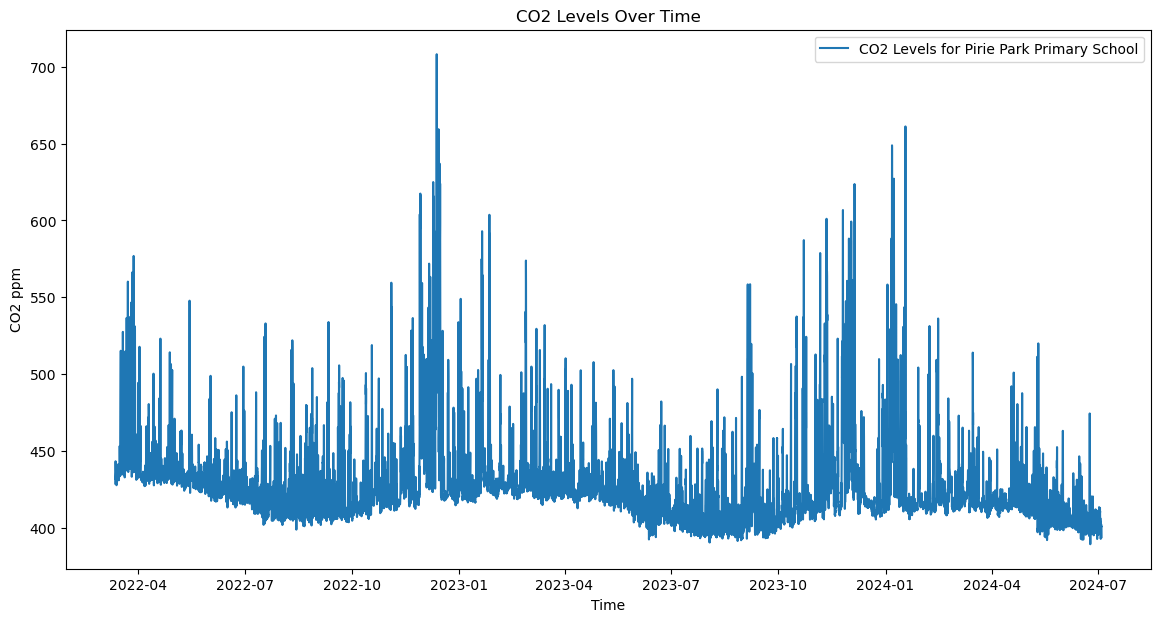

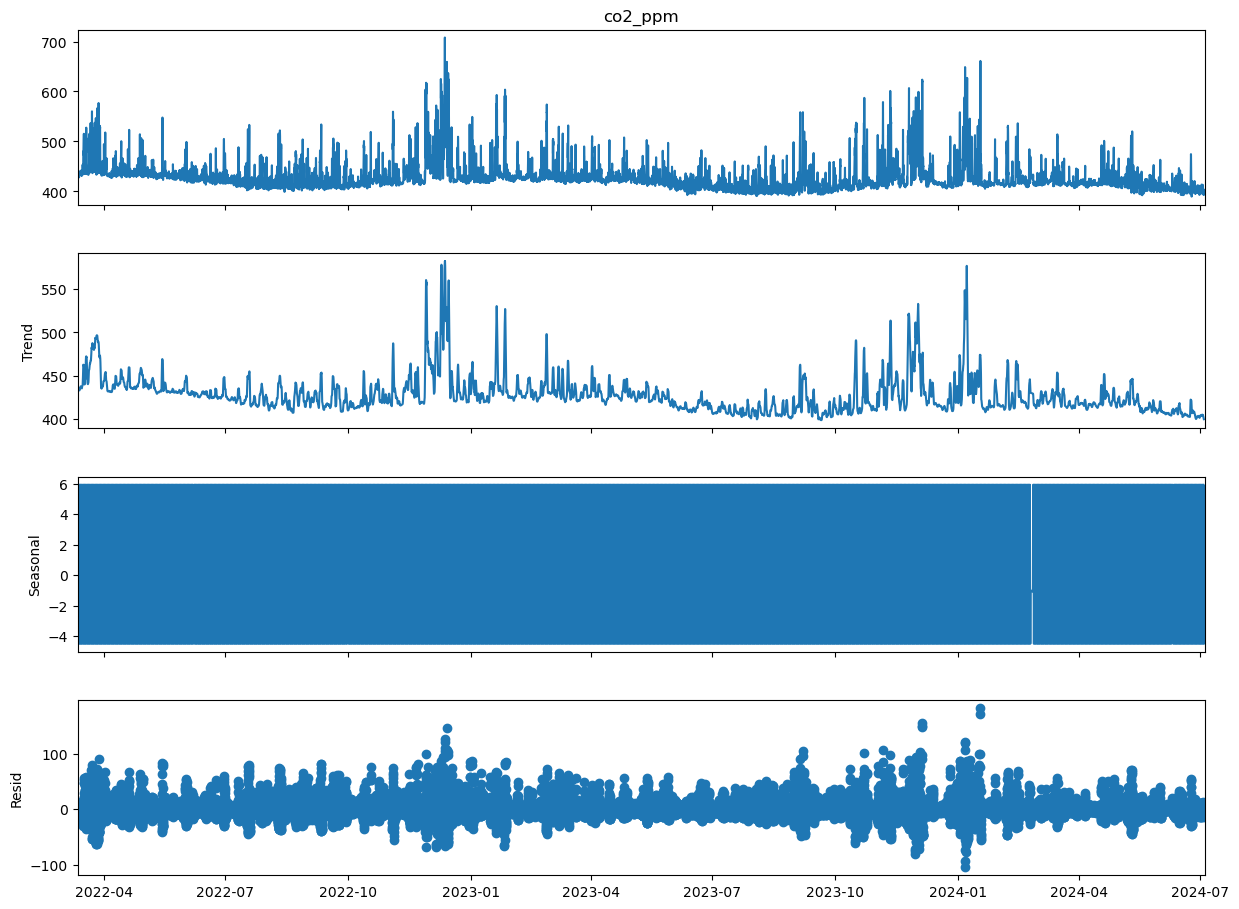

In [22]:
# Plotting CO2 levels over time
plt.figure(figsize=(14, 7))
plt.plot(merged_cleaned_df['local_timestamp'], merged_cleaned_df['co2_ppm'], label='CO2 Levels for Pirie Park Primary School')
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
plt.title('CO2 Levels Over Time')
plt.legend()
plt.show()

# Time series decomposition
decomposition = sm.tsa.seasonal_decompose(merged_cleaned_df.set_index('local_timestamp')['co2_ppm'], model='additive', period=24)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

### Correlation Analysis

Reference: https://www.geeksforgeeks.org/how-to-calculate-autocorrelation-in-python/

#### Correlation Matrix

In [23]:
# Correlation matrix
correlation_matrix = merged_cleaned_df[['co2_ppm', 'temp', 'pressure', 'humidity', 'wind_speed']].corr()
print(correlation_matrix)

             co2_ppm      temp  pressure  humidity  wind_speed
co2_ppm     1.000000 -0.347705  0.156640  0.043059   -0.276340
temp       -0.347705  1.000000  0.128695 -0.459712    0.192687
pressure    0.156640  0.128695  1.000000 -0.212719   -0.236850
humidity    0.043059 -0.459712 -0.212719  1.000000   -0.180811
wind_speed -0.276340  0.192687 -0.236850 -0.180811    1.000000


#### Scatter Plots

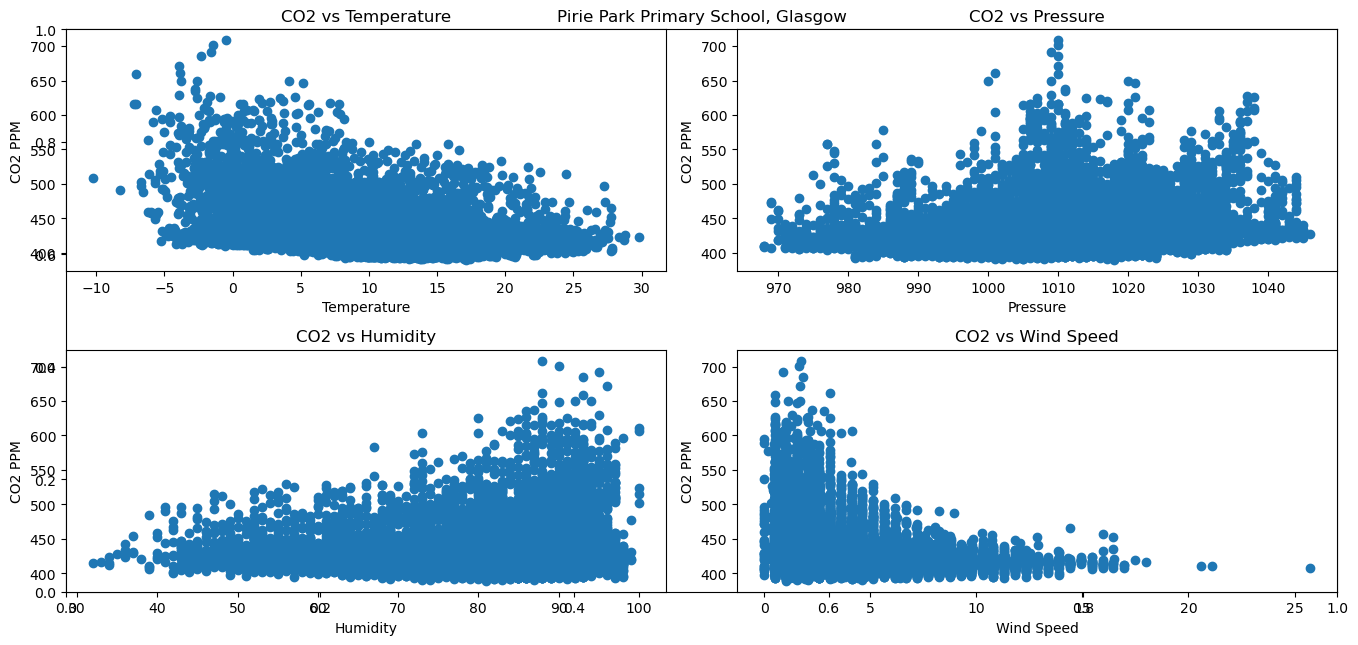

In [24]:
# Scatter plots
plt.figure(figsize=(14, 7))
plt.title("Pirie Park Primary School, Glasgow")

plt.subplot(2, 2, 1)
plt.scatter(merged_cleaned_df['temp'], merged_cleaned_df['co2_ppm'])
plt.xlabel('Temperature')
plt.ylabel('CO2 PPM')
plt.title('CO2 vs Temperature')

plt.subplot(2, 2, 2)
plt.scatter(merged_cleaned_df['pressure'], merged_cleaned_df['co2_ppm'])
plt.xlabel('Pressure')
plt.ylabel('CO2 PPM')
plt.title('CO2 vs Pressure')

plt.subplot(2, 2, 3)
plt.scatter(merged_cleaned_df['humidity'], merged_cleaned_df['co2_ppm'])
plt.xlabel('Humidity')
plt.ylabel('CO2 PPM')
plt.title('CO2 vs Humidity')

plt.subplot(2, 2, 4)
plt.scatter(merged_cleaned_df['wind_speed'], merged_cleaned_df['co2_ppm'])
plt.xlabel('Wind Speed')
plt.ylabel('CO2 PPM')
plt.title('CO2 vs Wind Speed')

plt.tight_layout()
plt.show()

There appears to be a slight trend where higher wind speeds are associated with lower CO2 concentrations. It suggests that wind speed might have a slight impact on dispersing CO2, leading to lower concentrations at higher wind speeds.

#### Correlation Heatmap

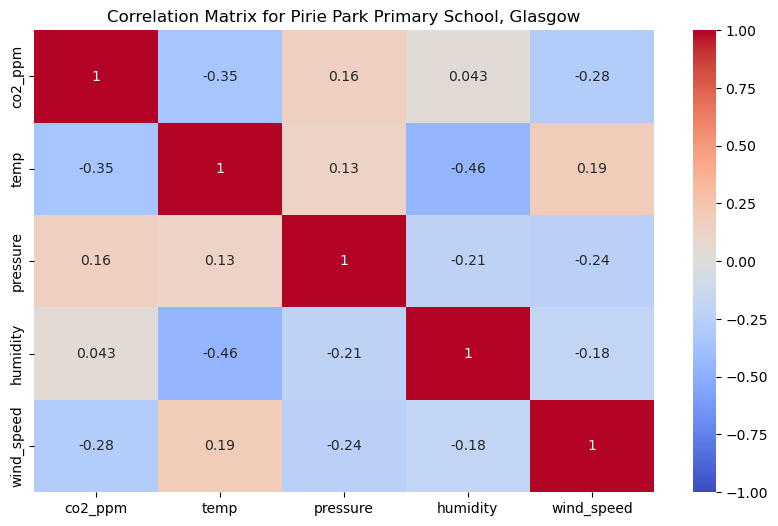

In [25]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Pirie Park Primary School, Glasgow')
plt.show()

#### Lag Plot

In [26]:
# Preparing data

# Extracting the CO2 values from the merged dataset
co2_data = merged_cleaned_df[['local_timestamp', 'co2_ppm']]

# Ensuring the timestamp is the index
co2_data.set_index('local_timestamp', inplace=True)

# Displaying top 15 data
co2_data.head(15)

,co2_ppm
local_timestamp,
2022-03-12 04:00:00,428.8
2022-03-12 05:00:00,432.6
2022-03-12 06:00:00,432.1
2022-03-12 07:00:00,431.8
2022-03-12 08:00:00,431.8
2022-03-12 09:00:00,432.4
2022-03-12 10:00:00,441.2
2022-03-12 11:00:00,443.3
2022-03-12 12:00:00,443.0


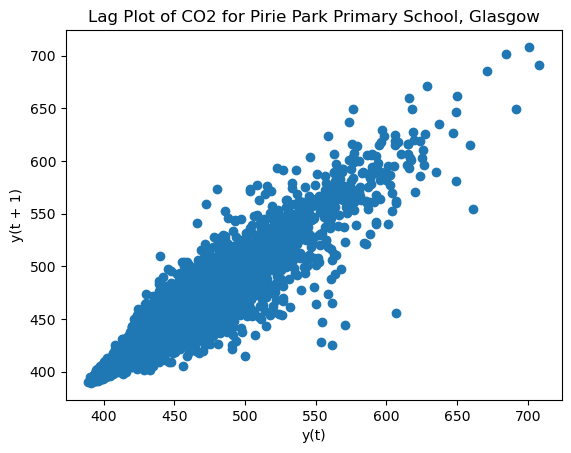

In [27]:
# Plotting the lag plot
pd.plotting.lag_plot(co2_data, lag=1)
plt.title('Lag Plot of CO2 for Pirie Park Primary School, Glasgow')
plt.show()

The lag plot shows the relationship between CO2 concentration at a given time (t) and the CO2 concentration at the next time step (t+1)

The strong linear relationship indicates a high correlation between consecutive time steps, suggesting that the CO2 concentration at time t+1 can be reasonably predicted based on the CO2 concentration at time t

#### Auto correlation Plot

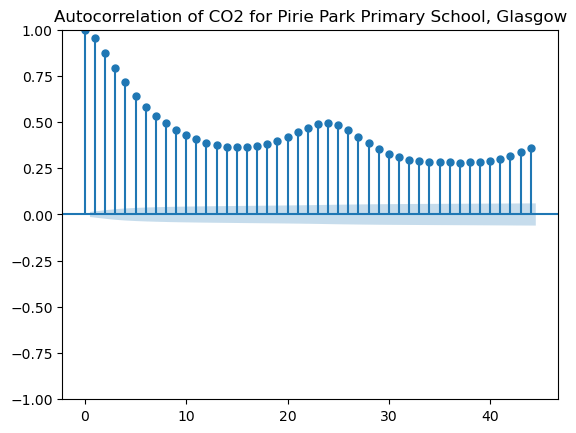

In [28]:
# Plotting the autocorrelation function
plot_acf(co2_data)
plt.title('Autocorrelation of CO2 for Pirie Park Primary School, Glasgow')
plt.show()

X-axis: Represents the lag (time steps).
Y-axis: Represents the autocorrelation value.

The plot shows how the CO2 concentration at a given time is correlated with its values at previous time steps.

The autocorrelation function (ACF) values start high (close to 1) at lag 0 (no lag) and gradually decrease as the lag increases, indicating a strong temporal correlation.

Periodic fluctuations in the autocorrelation values suggest some seasonality or cyclic behavior in the CO2 concentration over time.

The blue shaded area represents the confidence intervals. Values outside this region indicate significant correlations.

#### Lagged Data and Correlation Matrix

In [29]:
# Creating lagged dataset for correlation computation
values = pd.DataFrame(co2_data.values)
dataframe = pd.concat([values.shift(3), values.shift(2), values.shift(1), values], axis=1)
dataframe.columns = ['t-3', 't-2', 't-1', 't']

# Computing the correlation matrix
result = dataframe.corr()
print(result)

          t-3       t-2       t-1         t
t-3  1.000000  0.954648  0.875381  0.792760
t-2  0.954648  1.000000  0.954650  0.875388
t-1  0.875381  0.954650  1.000000  0.954653
t    0.792760  0.875388  0.954653  1.000000


### Distribution Plots

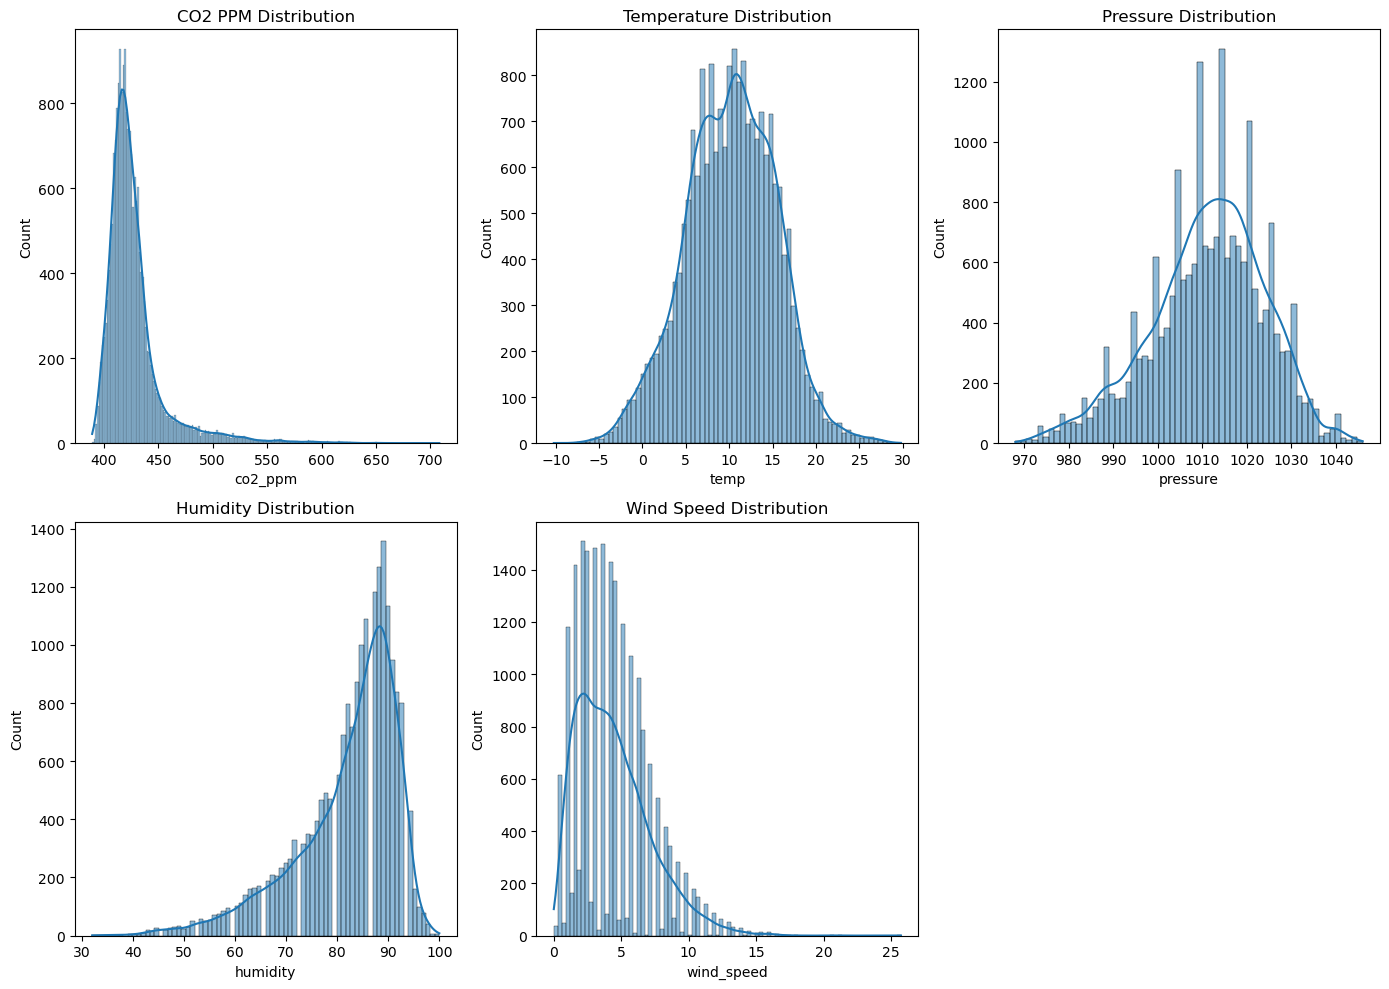

In [30]:
# Distribution plots
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
sns.histplot(merged_cleaned_df['co2_ppm'], kde=True)
plt.title('CO2 PPM Distribution')

plt.subplot(2, 3, 2)
sns.histplot(merged_cleaned_df['temp'], kde=True)
plt.title('Temperature Distribution')

plt.subplot(2, 3, 3)
sns.histplot(merged_cleaned_df['pressure'], kde=True)
plt.title('Pressure Distribution')

plt.subplot(2, 3, 4)
sns.histplot(merged_cleaned_df['humidity'], kde=True)
plt.title('Humidity Distribution')

plt.subplot(2, 3, 5)
sns.histplot(merged_cleaned_df['wind_speed'], kde=True)
plt.title('Wind Speed Distribution')

plt.tight_layout()
plt.show()

### Box Plots

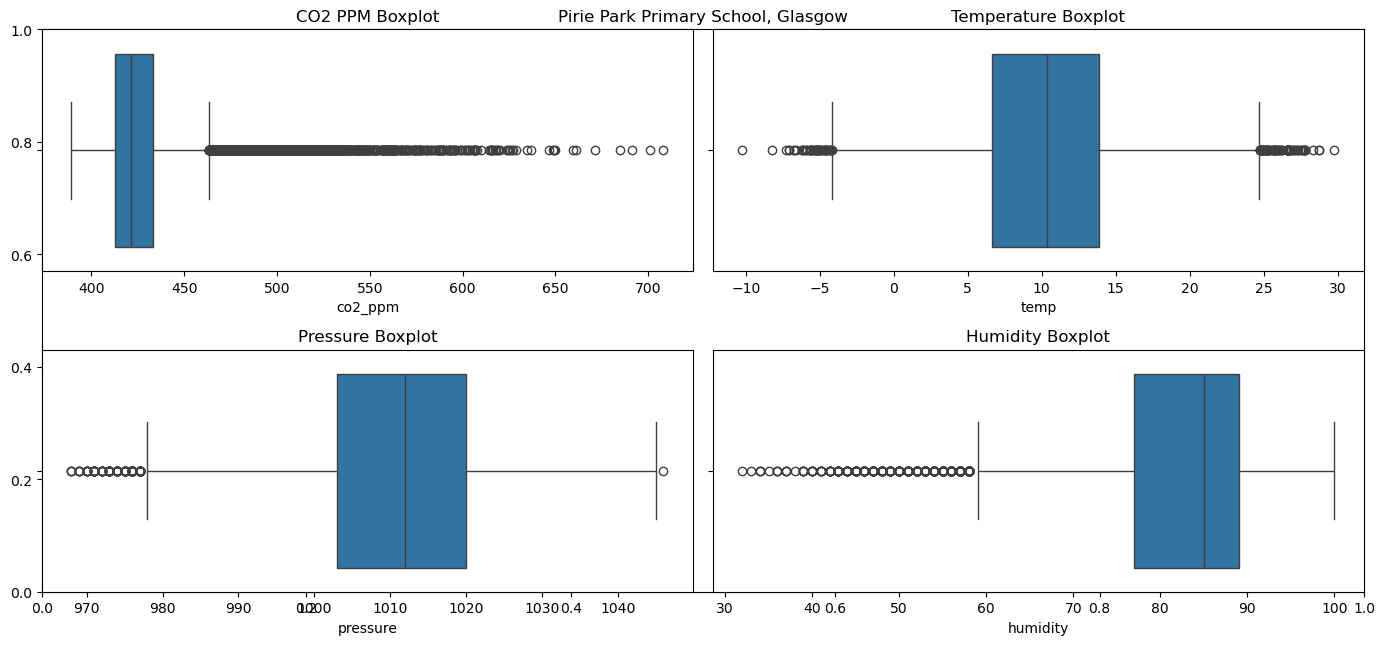

In [31]:
# Boxplots
plt.figure(figsize=(14, 7))
plt.title("Pirie Park Primary School, Glasgow")

plt.subplot(2, 2, 1)
sns.boxplot(x=merged_cleaned_df['co2_ppm'])
plt.title('CO2 PPM Boxplot')

plt.subplot(2, 2, 2)
sns.boxplot(x=merged_cleaned_df['temp'])
plt.title('Temperature Boxplot')

plt.subplot(2, 2, 3)
sns.boxplot(x=merged_cleaned_df['pressure'])
plt.title('Pressure Boxplot')

plt.subplot(2, 2, 4)
sns.boxplot(x=merged_cleaned_df['humidity'])
plt.title('Humidity Boxplot')

plt.tight_layout()
plt.show()

### Rolling Mean

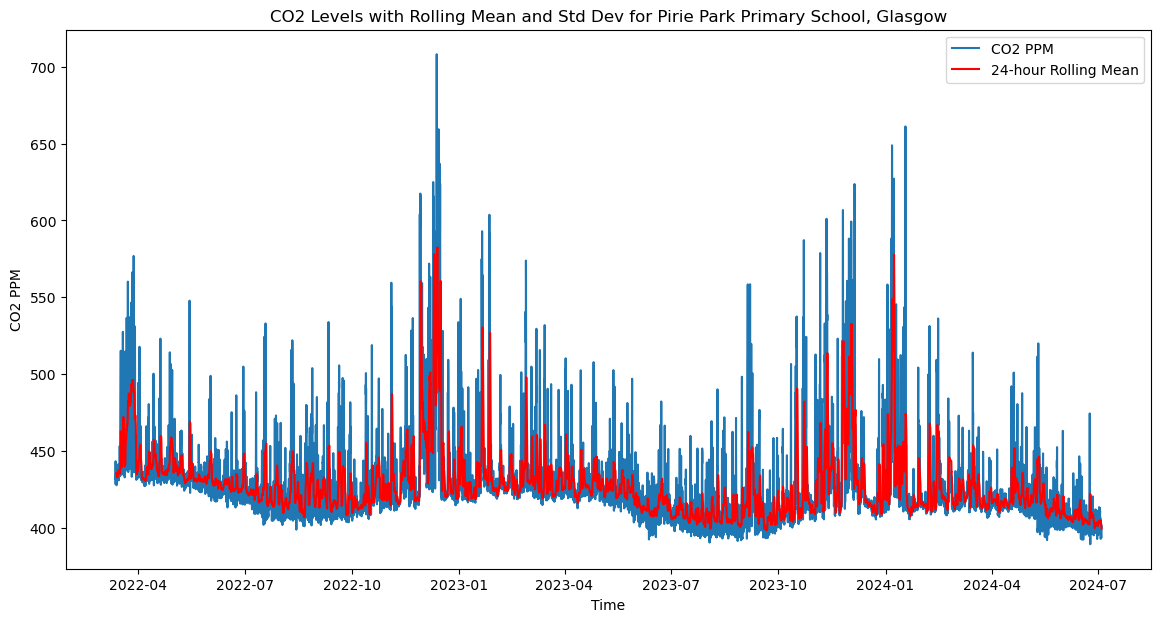

In [32]:
# Rolling mean and standard deviation
rolling_mean = merged_cleaned_df['co2_ppm'].rolling(window=24).mean() # Averaging 24 hour window
rolling_std = merged_cleaned_df['co2_ppm'].rolling(window=24).std()

plt.figure(figsize=(14, 7))
plt.plot(merged_cleaned_df['local_timestamp'], merged_cleaned_df['co2_ppm'], label='CO2 PPM')
plt.plot(merged_cleaned_df['local_timestamp'], rolling_mean, color='red', label='24-hour Rolling Mean')
# plt.plot(merged_cleaned_df['local_timestamp'], rolling_std, color='black', label='Rolling Std')
plt.xlabel('Time')
plt.ylabel('CO2 PPM')
plt.title('CO2 Levels with Rolling Mean and Std Dev for Pirie Park Primary School, Glasgow')
plt.legend()
plt.show()


In the above Rolling Mean plot:

*   The blue line demonstrates significant day-to-day fluctuations in CO2 levels.
*   24 hour rolling mean: Calculated by averaging the CO2 levels over a 24-hour window, which smooths out the short-term fluctuations. The red line is smoother and helps identify longer-term trends in CO2 concentration. There are noticeable peaks during certain periods (could be related to seasonal changes).

*   The rolling mean or average has smoothed out the noise from the data, making it easier to comprehend the underlying trend.

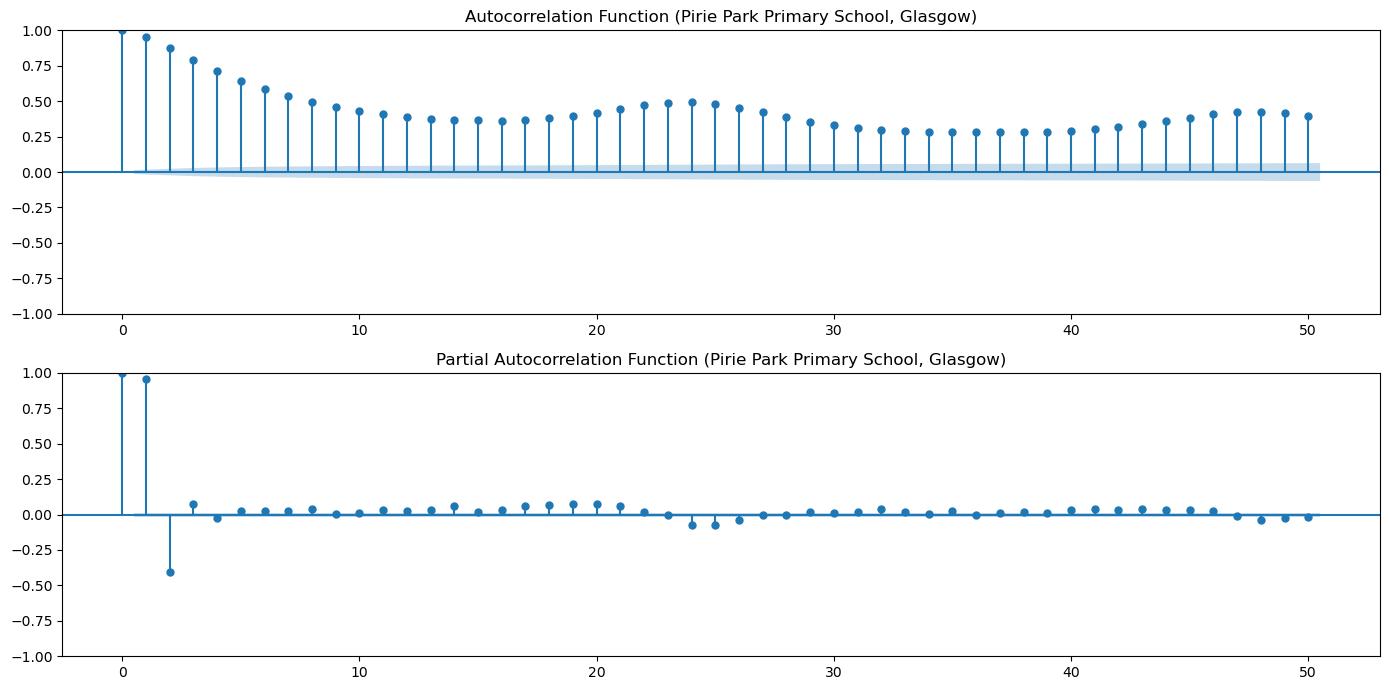

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plot_acf(merged_cleaned_df['co2_ppm'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (Pirie Park Primary School, Glasgow)')

plt.subplot(2, 1, 2)
plot_pacf(merged_cleaned_df['co2_ppm'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (Pirie Park Primary School, Glasgow)')

plt.tight_layout()
plt.show()

# Modelling 

### Preprocessing for LSTM

In [34]:
# Setting seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [35]:
# Converting the DataFrame to a NumPy array
merged_data = merged_cleaned_df[['co2_ppm', 'temp', 'pressure', 'humidity', 'wind_speed']].values

In [36]:
# Normalizing the data to a fixed range
scaler = MinMaxScaler() ## to range [0,1]
merged_data_scaled = scaler.fit_transform(merged_data)

In [37]:
window_size = 48 ## Window_size of 48 means past 2 days are used to predict the next hour

In [38]:
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        labels.append(data[i + window_size, 0])  # Predicting the next CO2 value. '0' indicates the first column (co2) which is the target value
    return np.array(sequences), np.array(labels)

### Splitting

In [39]:
# Create sequences (X) and labels (y)
X, y = create_sequences(merged_data_scaled, window_size)

#Splitting the data into train and temporary sets (80% train, 20% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)

# Splitting the temporary data into validation and test sets (50% each of the temporary set)
# This results in 80% train, 10% validation, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshaping the data to be compatible with LSTM input (samples, window_size, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2])) ## .shape[2] (3rd element) used to ensure that the number of features dimension is dynamically captured
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Checking the shape of the data
print("X_train shape:", X_train.shape)  # Should be (num_samples, window_size, num_features)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16128, 48, 5)
X_val shape: (2016, 48, 5)
X_test shape: (2017, 48, 5)
y_train shape: (16128,)
y_val shape: (2016,)
y_test shape: (2017,)


In [40]:
# Checks
print("X_train length:", len(X_train))
print("y_train length:", len(y_train))
print("X type:", (type(X)))

X_train length: 16128
y_train length: 16128
X type: <class 'numpy.ndarray'>


In [41]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True) ## Stops training if the validation loss does not improve for 4 consecutive epochs.
## Restores the model weights to the best epoch where the validation loss was lowest.

## LSTM

In [42]:
# One LSTM Layer Architecture
model1 = Sequential()
model1.add(LSTM(50, return_sequences=False, input_shape=(window_size, merged_data_scaled.shape[1])))  # 50 units
model1.add(Dense(1))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# Save the initial weights for Model 1
initial_weights_model1 = model1.get_weights()

# Reset the model to its initial state before training 
model1.set_weights(initial_weights_model1)

In [44]:
# Compiling the model
model1.compile(optimizer='adam', loss='mean_squared_error') # lr default = 0.001

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Training the model
history_model1 = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping]) ## verbose=1: Progress bar. Displays a progress bar for each epoch.

Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0012 - val_loss: 9.1630e-04
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.6223e-04 - val_loss: 7.2701e-04
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.7864e-04 - val_loss: 6.2357e-04
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.5289e-04 - val_loss: 5.5455e-04
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.4432e-04 - val_loss: 5.0032e-04
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.3678e-04 - val_loss: 4.9280e-04
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.3217e-04 - val_loss: 4.9069e-04
Epoch 9/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.2857e-04 - val_loss: 4.8514e-04
Epoch 10/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.2492e-04 - val_loss: 4.7616e-04
Epoch 11/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.2071e-04

In [46]:
# Extracting loss values 
train_loss_1 = history_model1.history['loss']
val_loss_1 = history_model1.history['val_loss']

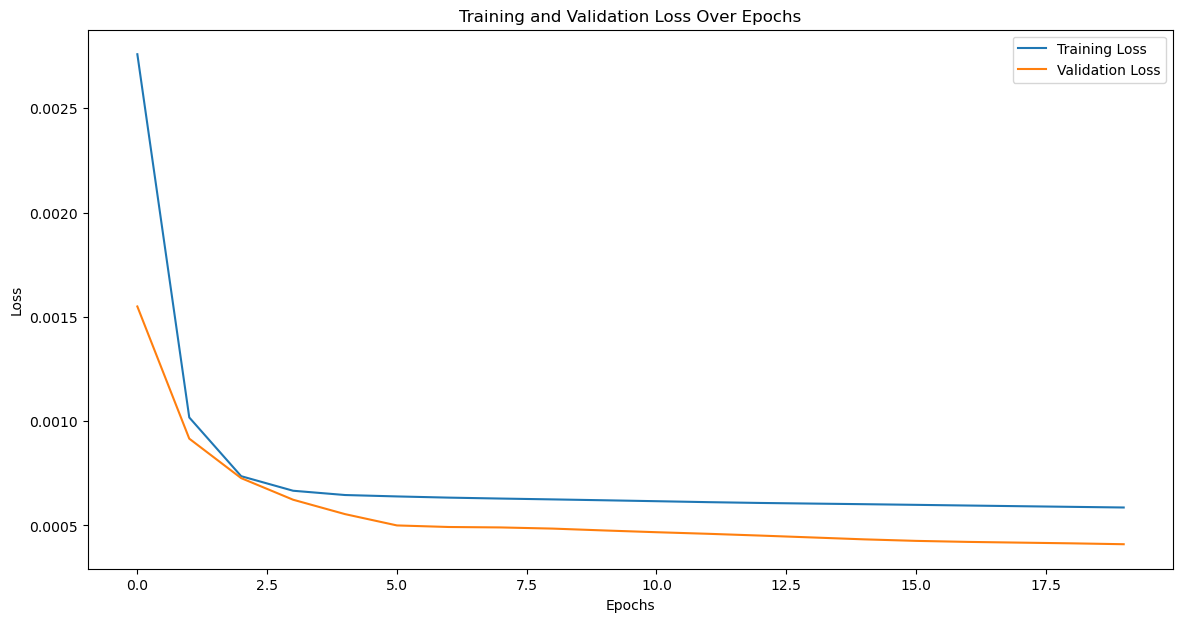

In [47]:
# Plotting train and valid loss
plt.figure(figsize=(14, 7))
plt.plot(train_loss_1, label='Training Loss')
plt.plot(val_loss_1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [48]:
# Evaluating the model on the test set
test_loss_1 = model1.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_1}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9830e-04
Test Loss: 0.00017062269034795463


In [49]:
# Making predictions on the test set
y_pred_1 = model1.predict(X_test)

# Inverse transforming predictions and actual values to their original scale
y_pred_inv_1 = scaler.inverse_transform(np.concatenate((y_pred_1, np.zeros((y_pred_1.shape[0], merged_data_scaled.shape[1] - 1))), axis=1))[:, 0]
y_test_inv_1 = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], merged_data_scaled.shape[1] - 1))), axis=1))[:, 0]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### Evaluation

In [50]:
# Calculate evaluation metrics
mse_1 = mean_squared_error(y_test_inv_1, y_pred_inv_1)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(y_test_inv_1, y_pred_inv_1)
mae_1 = mean_absolute_error(y_test_inv_1, y_pred_inv_1)

print(f'Mean Squared Error (MSE): {mse_1}')
print(f'Root Mean Squared Error (RMSE): {rmse_1}')
print(f'R-squared (R^2): {r2_1}')
print(f'Mean Absolute Error (MAE): {mae_1}')

Mean Squared Error (MSE): 17.351850362145615
Root Mean Squared Error (RMSE): 4.165555228555446
R-squared (R^2): 0.9316989821570166
Mean Absolute Error (MAE): 2.413077778418199


#### Plots

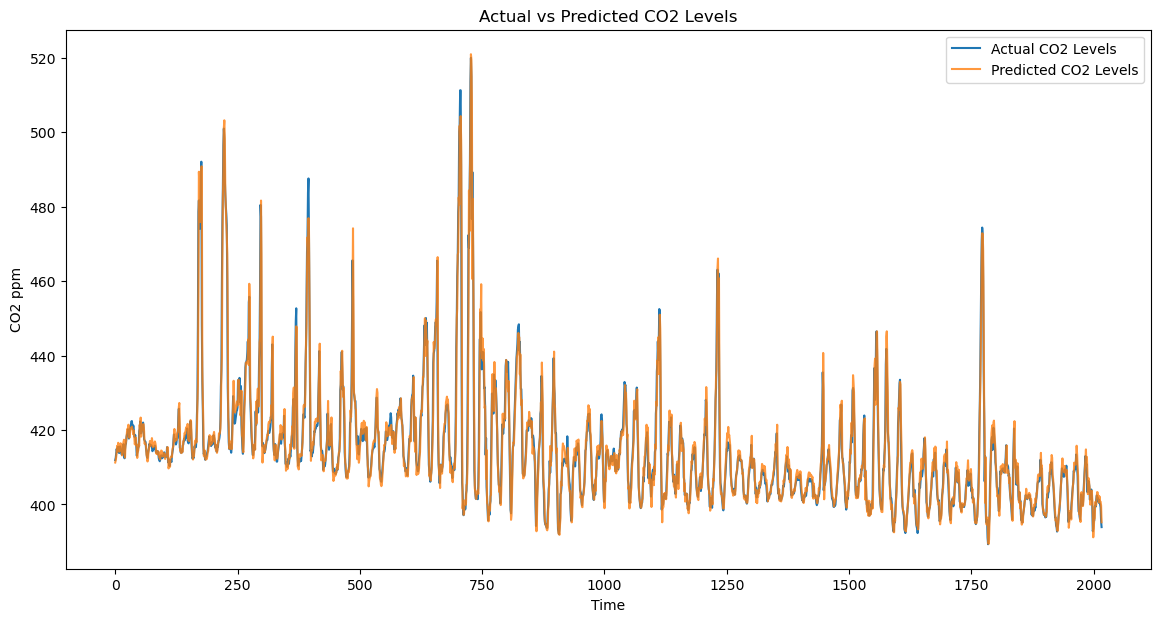

In [51]:
# Plotting predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv_1, label='Actual CO2 Levels')
plt.plot(y_pred_inv_1, label='Predicted CO2 Levels', alpha = 0.8) # alpha for transparency
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

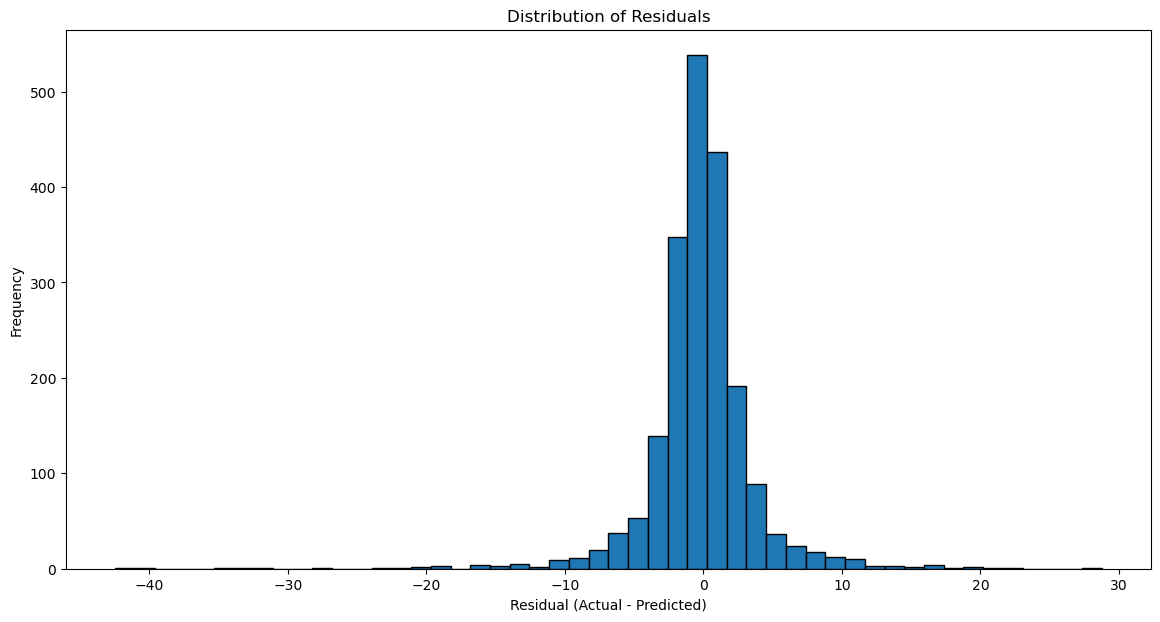

In [52]:
# Plotting residuals
residuals_1 = y_test_inv_1 - y_pred_inv_1
plt.figure(figsize=(14, 7))
plt.hist(residuals_1, bins=50, edgecolor='black')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

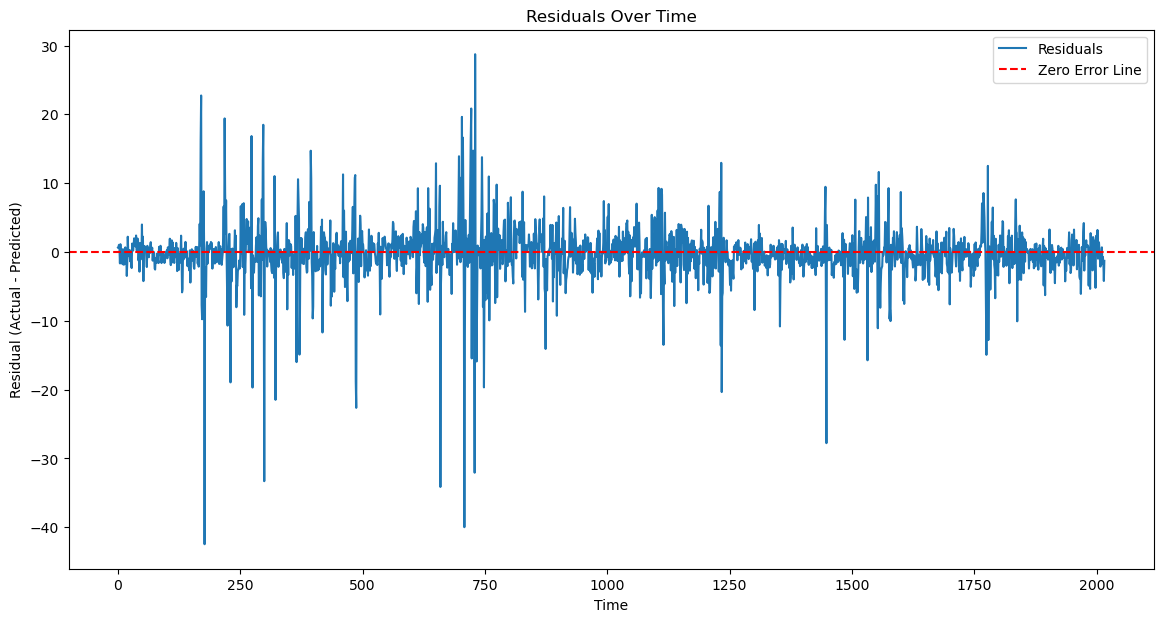

In [53]:
# Plotting residuals over time
plt.figure(figsize=(14, 7))
plt.plot(residuals_1, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.legend()
plt.show()


## 2nd LSTM
2 LSTM layers and 64 units per layer

In [54]:
# LSTM architecture
model2 = Sequential()
# First LSTM layer
model2.add(LSTM(50, return_sequences=True, input_shape=(window_size, merged_data_scaled.shape[1])))
model2.add(Dropout(0.2)) # Dropout layer. 20% of the neurons are randomly dropped during training to prevent overfitting
# Second LSTM layer
model2.add(LSTM(50)) # No return_sequences as this is the last layer
model2.add(Dropout(0.2))
# Dense layer
model2.add(Dense(1)) ## output layer, with a single neuron, as we are predicting a single continuous value (the CO2 level)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
# Save the initial weights for Model 2
initial_weights_model2 = model2.get_weights()

# Reset the model to its initial state before training 
model2.set_weights(initial_weights_model2)

In [56]:
# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error') # lr default = 0.001

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 48, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Training the model
history_model2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping]) ## verbose=1: Progress bar. Displays a progress bar for each epoch.

Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0073 - val_loss: 0.0021
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0018 - val_loss: 8.6071e-04
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0013 - val_loss: 7.2017e-04


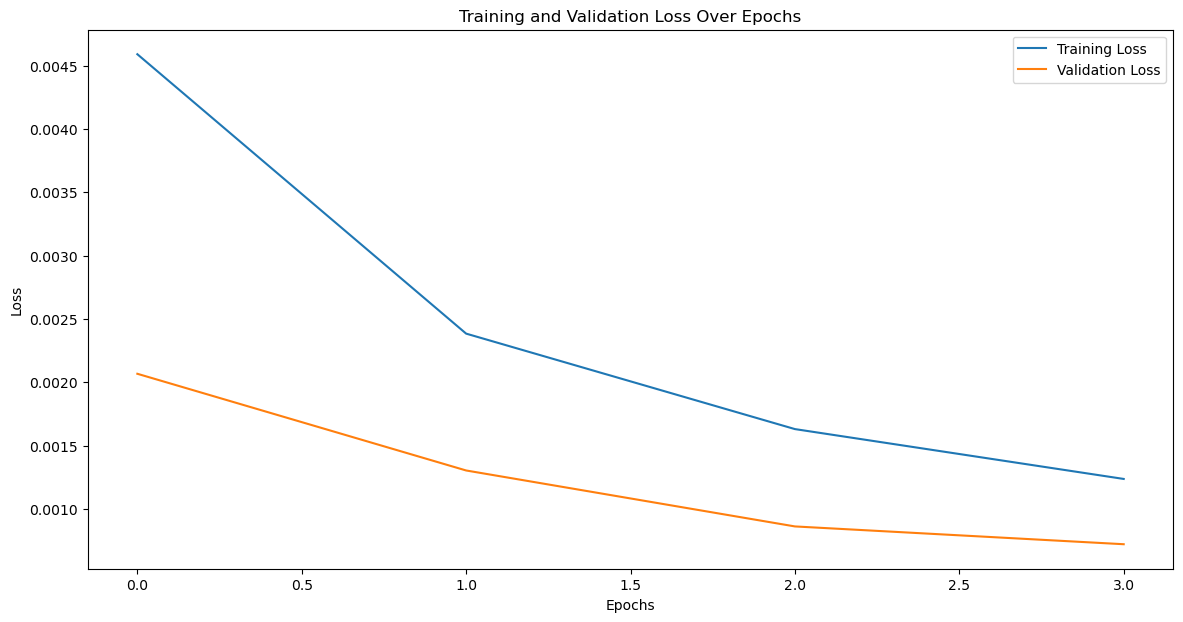

In [58]:
# Extracting loss values 
train_loss_2 = history_model2.history['loss']
val_loss_2 = history_model2.history['val_loss']

# Plotting train and valid loss
plt.figure(figsize=(14, 7))
plt.plot(train_loss_2, label='Training Loss')
plt.plot(val_loss_2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [59]:
# Evaluate the model on the test set
test_loss_2 = model2.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_2}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010   
Test Loss: 0.0009555527358315885


In [60]:
# Make predictions on the test set
y_pred_2 = model2.predict(X_test)

# Inverse transform predictions and actual values to their original scale
y_pred_inv_2 = scaler.inverse_transform(
    np.concatenate(
        (y_pred_2, np.zeros((y_pred_2.shape[0], merged_data_scaled.shape[1] - 1))), axis=1
    )
)[:, 0]
y_test_inv_2 = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], merged_data_scaled.shape[1] - 1))), axis=1))[:, 0]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Evaluation

In [61]:
# Calculate evaluation metrics
mse_2 = mean_squared_error(y_test_inv_2, y_pred_inv_2)
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_test_inv_2, y_pred_inv_2)
mae_2 = mean_absolute_error(y_test_inv_2, y_pred_inv_2)

print(f'Mean Squared Error (MSE): {mse_2}')
print(f'Root Mean Squared Error (RMSE): {rmse_2}')
print(f'R-squared (R^2): {r2_2}')
print(f'Mean Absolute Error (MAE): {mae_2}')

Mean Squared Error (MSE): 97.17703478386454
Root Mean Squared Error (RMSE): 9.85784128416889
R-squared (R^2): 0.6174880345222029
Mean Absolute Error (MAE): 7.224545831771457


#### Plots

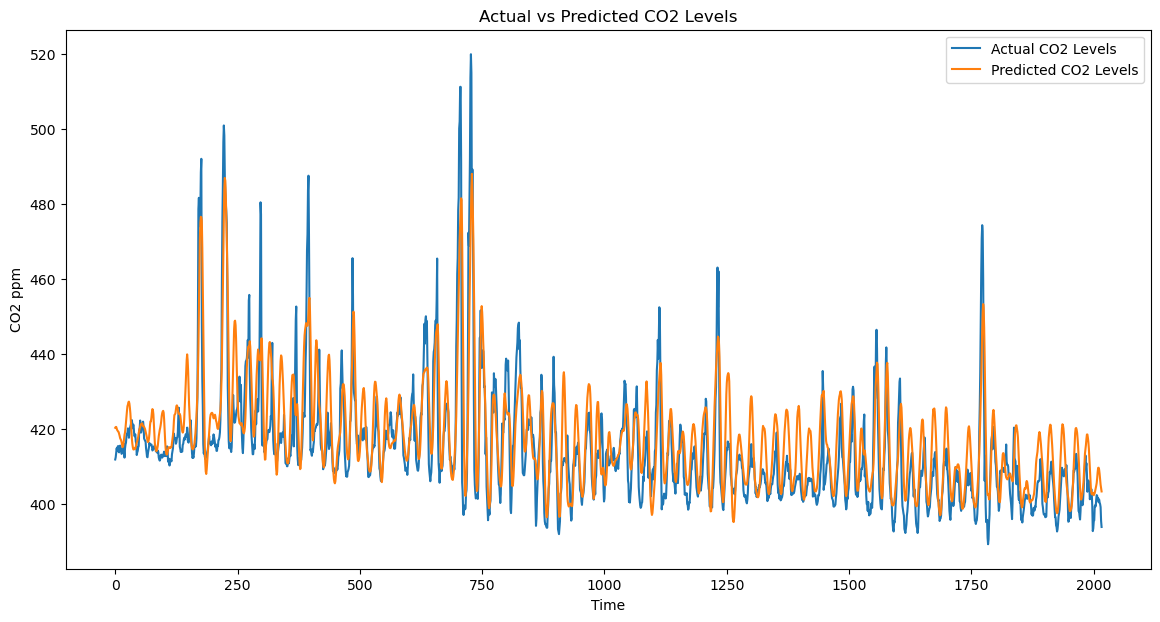

In [62]:
# Plotting predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv_2, label='Actual CO2 Levels')
plt.plot(y_pred_inv_2, label='Predicted CO2 Levels') # alpha for transparency
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

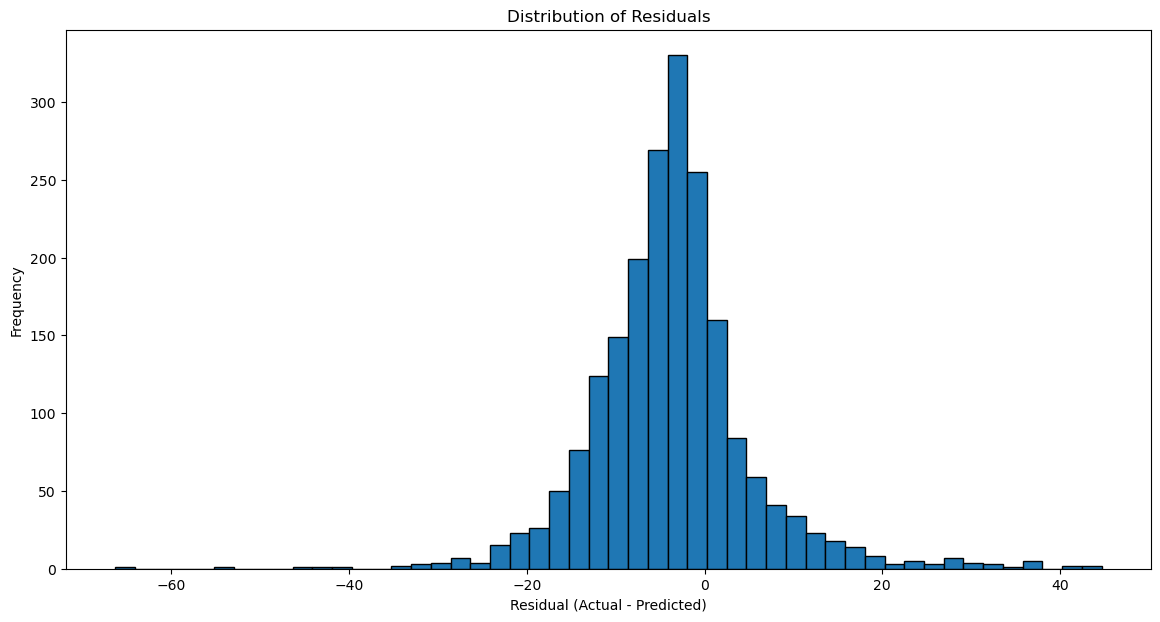

In [63]:
# Plotting residuals
residuals_2 = y_test_inv_2 - y_pred_inv_2
plt.figure(figsize=(14, 7))
plt.hist(residuals_2, bins=50, edgecolor='black')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

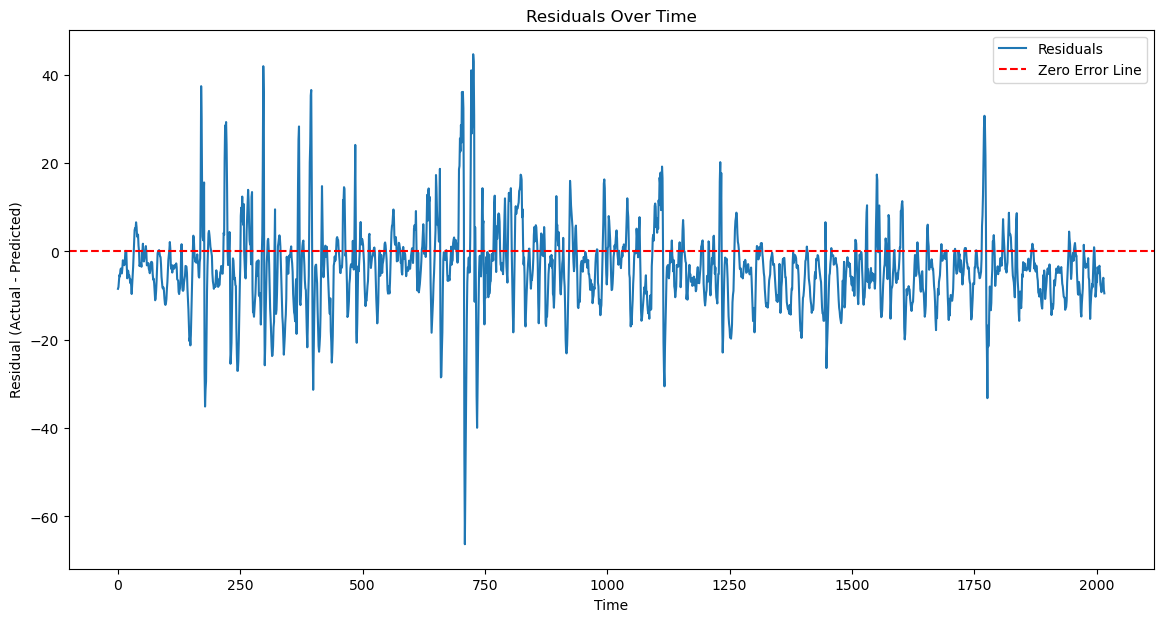

In [64]:
# Plotting residuals over time
plt.figure(figsize=(14, 7))
plt.plot(residuals_2, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

## 3rd LSTM
3 layers of LSTM

In [65]:
# Three LSTM layers
model3 = Sequential()
# First LSTM layer
model3.add(LSTM(50, return_sequences=True, input_shape=(window_size, X_train.shape[2])))
model3.add(Dropout(0.2)) # Dropout layer. 20% of the neurons are randomly dropped during training to prevent overfitting
# Second LSTM layer
model3.add(LSTM(50, return_sequences=True))
model3.add(Dropout(0.2))
# Third LSTM layer
model3.add(LSTM(50)) # No return_sequences because it is the last layer
model3.add(Dropout(0.2))
# Dense layer
model3.add(Dense(1)) ## output layer, with a single neuron, as we are predicting a single continuous value (the CO2 level)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
# Save the initial weights for Model 3
initial_weights_model3 = model3.get_weights()

# Reset the model to its initial state before training
model3.set_weights(initial_weights_model3)

In [67]:
# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error') # lr default = 0.001

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 48, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 48, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,651 (201.76 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Training the model with early stopping
history_model3 = model3.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0072 - val_loss: 0.0022
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0018 - val_loss: 8.1049e-04
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0014 - val_loss: 5.9095e-04


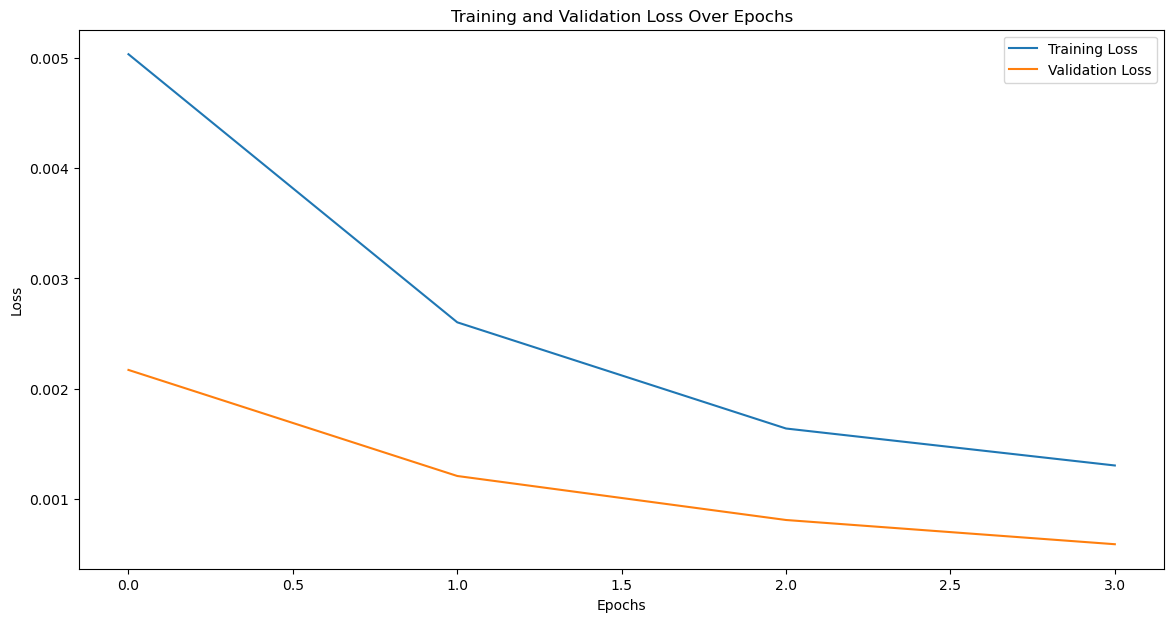

In [69]:
# Extracting loss values 
train_loss_3 = history_model3.history['loss']
val_loss_3 = history_model3.history['val_loss']

# Plotting train and valid loss
plt.figure(figsize=(14, 7))
plt.plot(train_loss_3, label='Training Loss')
plt.plot(val_loss_3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [70]:
# Evaluate the model on the test set
test_loss_3 = model3.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_3}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012  
Test Loss: 0.001114766113460064


In [71]:
# Make predictions on the test set
y_pred_3 = model3.predict(X_test)

# Inverse transform predictions and actual values to their original scale
y_pred_inv_3 = scaler.inverse_transform(np.concatenate((y_pred_3, np.zeros((y_pred_3.shape[0], merged_data_scaled.shape[1] - 1))), axis=1))[:, 0]
y_test_inv_3 = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], merged_data_scaled.shape[1] - 1))), axis=1))[:, 0]

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


### Evaluation

In [72]:
# Calculate evaluation metrics
mse_3 = mean_squared_error(y_test_inv_3, y_pred_inv_3)
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_test_inv_3, y_pred_inv_3)
mae_3 = mean_absolute_error(y_test_inv_3, y_pred_inv_3)

print(f'Mean Squared Error (MSE): {mse_3}')
print(f'Root Mean Squared Error (RMSE): {rmse_3}')
print(f'R-squared (R^2): {r2_3}')
print(f'Mean Absolute Error (MAE): {mae_3}')

Mean Squared Error (MSE): 113.36858489285953
Root Mean Squared Error (RMSE): 10.64746847343816
R-squared (R^2): 0.5537542349665874
Mean Absolute Error (MAE): 7.974766961583585


R**2 has decreased significantly meaning the model is too complex to generalize the data well

#### Plots

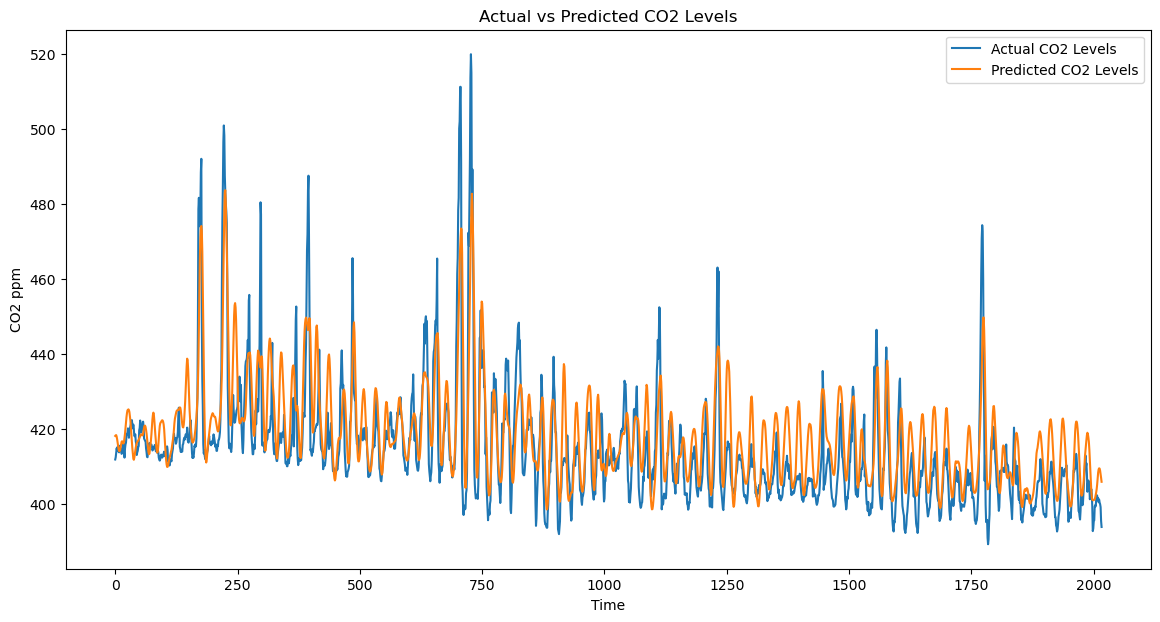

In [73]:
# Plotting predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv_3, label='Actual CO2 Levels')
plt.plot(y_pred_inv_3, label='Predicted CO2 Levels') # alpha for transparency
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

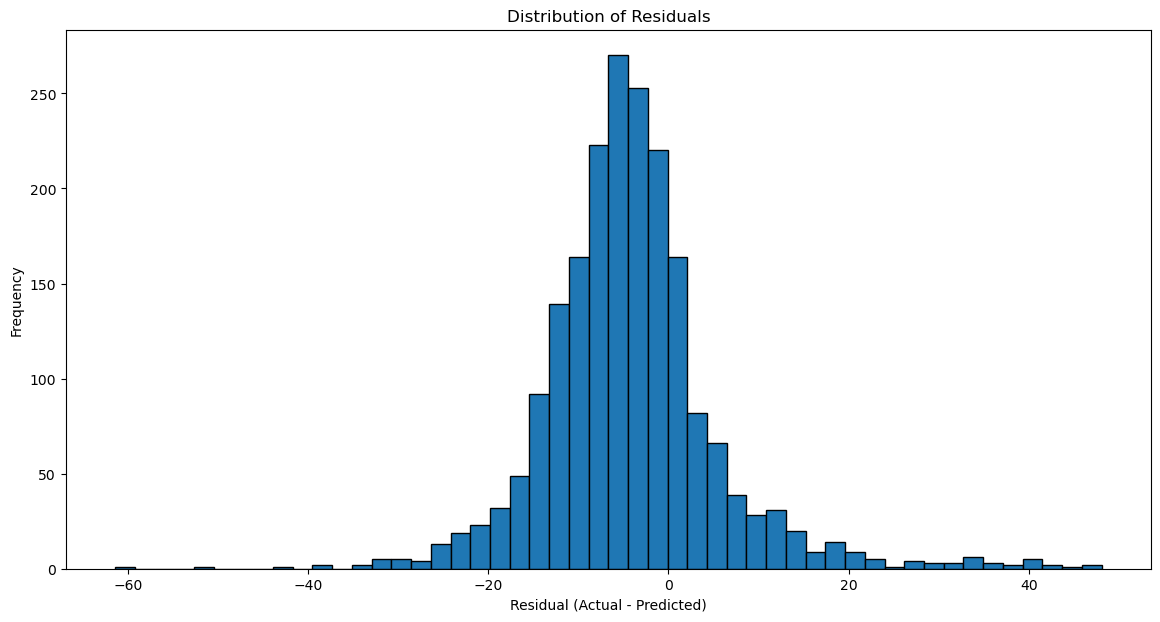

In [74]:
# Plotting residuals
residuals_3 = y_test_inv_3 - y_pred_inv_3
plt.figure(figsize=(14, 7))
plt.hist(residuals_3, bins=50, edgecolor='black')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

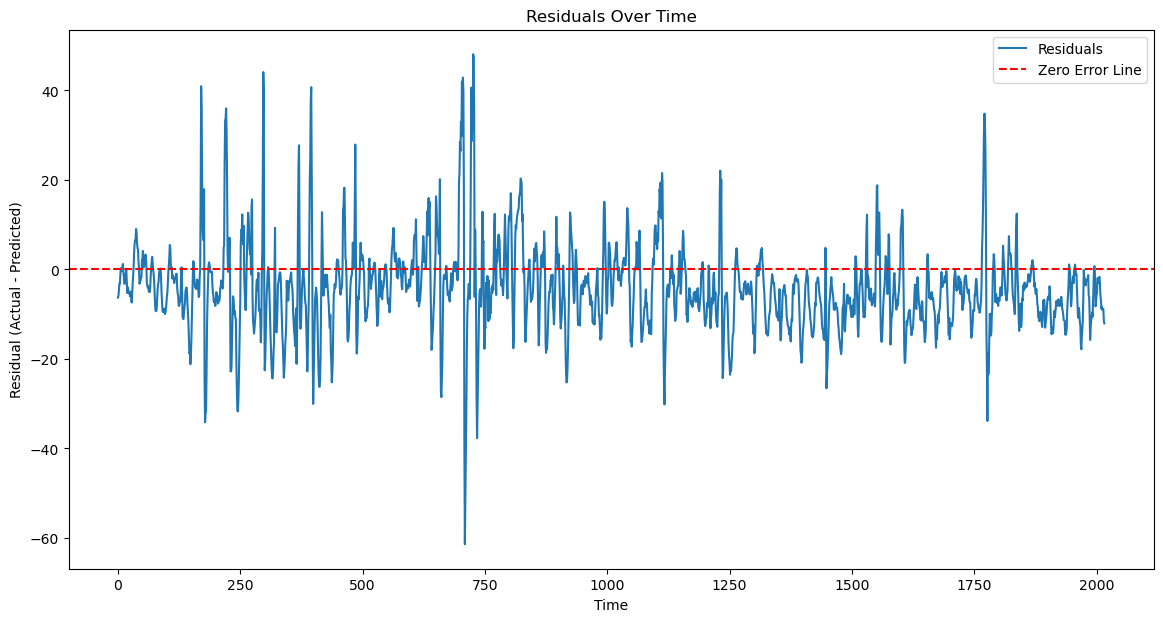

In [75]:
# Plotting residuals over time
plt.figure(figsize=(14, 7))
plt.plot(residuals_3, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

## Comparing the Models

     Model         MSE       RMSE        R²       MAE
0  Model 1   17.351850   4.165555  0.931699  2.413078
1  Model 2   97.177035   9.857841  0.617488  7.224546
2  Model 3  113.368585  10.647468  0.553754  7.974767


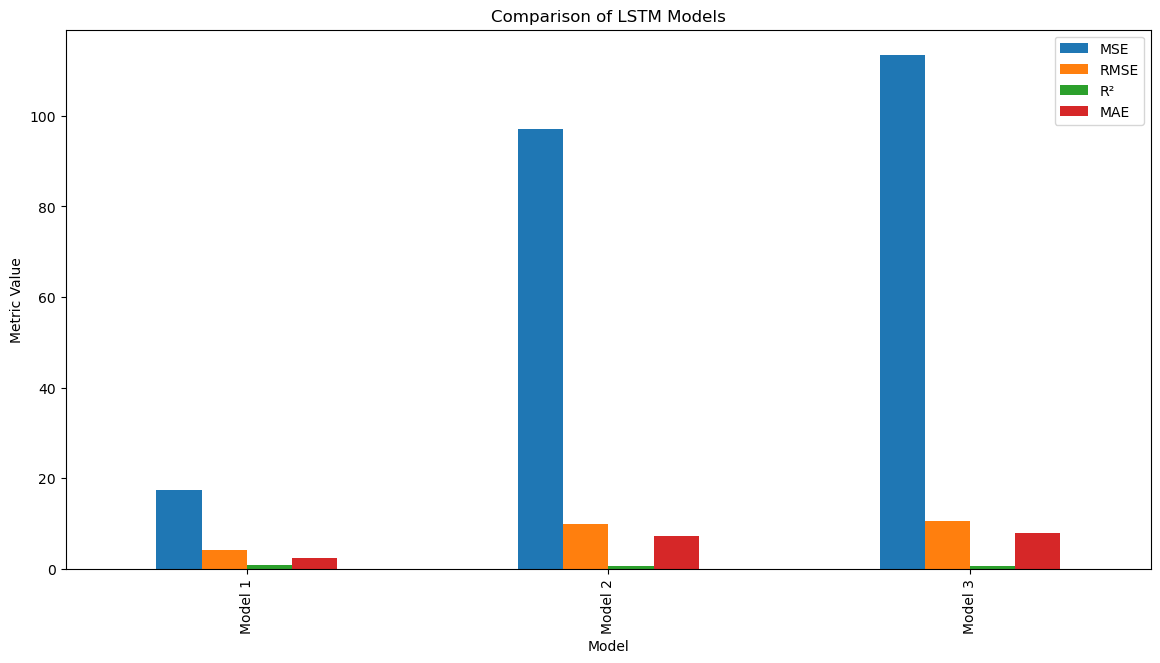

In [76]:
# Gathering the evaluation metrics for all models
metrics = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'MSE': [mse_1, mse_2, mse_3],
    'RMSE': [rmse_1, rmse_2, rmse_3],
    'R²': [r2_1, r2_2, r2_3],
    'MAE': [mae_1, mae_2, mae_3]
}

# Creating a DataFrame to organize the metrics
metrics_df = pd.DataFrame(metrics)

# Displaying the comparison table
print(metrics_df)

# Visualizing the results
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(14, 7), title='Comparison of LSTM Models')
plt.ylabel('Metric Value')
plt.show()

In [77]:
# On the basis of the above results
best_initial_weights = model1.get_weights()

## Fine-Tuning the best model & Hyperparameter Optimisation

Taking the best model from above and performing optimisation to improve the results. 

In [78]:
# Defining the hyperparameter grid
unit_options = [50, 100, 150, 200]
learning_rate_options = [0.01, 0.001, 0.0001]
batch_size = 32

# Storing the best configuration and results
best_val_loss = float('inf')
best_params = {}

# Hyperparameter optimization loop using the pre-trained best model
for units in unit_options:
    for lr in learning_rate_options:
        print(f"Fine-tuning model with units={units}, learning_rate={lr}, batch_size={batch_size}")
        
        # Reset the model to its pre-trained weights to maintain consistency
        model1.set_weights(best_initial_weights)
        
        # Re-compiling the model with the new learning rate
        model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error')
        
        # Fine-tuning the model (continue training)
        history = model1.fit(X_train, y_train, epochs=10, batch_size=batch_size,
                                validation_data=(X_val, y_val), verbose=1,
                                callbacks=[early_stopping])
        
        # Evaluating the model on the validation data
        val_loss = min(history.history['val_loss'])
        
        # Checking if this is the best model so far
        if val_loss < best_val_loss:
            best_params = {'units': units, 'learning_rate': lr, 'batch_size': batch_size}
            best_lstm_co2xweather_model = tf.keras.models.clone_model(model1)  # Cloning the best model
            best_lstm_co2xweather_model.set_weights(model1.get_weights())  # Copying weights

# Final training on the entire training set with the best hyperparameters
best_lstm_co2xweather_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), 
                           loss='mean_squared_error')

best_lstm_co2xweather_model.fit(X_train, y_train, epochs=10, batch_size=best_params['batch_size'],
              validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

# Final evaluation on the test set with the best fine-tuned model
test_loss = best_lstm_co2xweather_model.evaluate(X_test, y_test)
print(f'Best Fine-tuned Model Test Loss: {test_loss}')
print(f'Best Parameters: {best_params}')

Fine-tuning model with units=50, learning_rate=0.01, batch_size=32
Epoch 1/10


504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.9881e-04 - val_loss: 4.6896e-04
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.5358e-04 - val_loss: 4.8569e-04
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.5011e-04 - val_loss: 4.8294e-04
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.4758e-04 - val_loss: 4.8493e-04
Fine-tuning model with units=50, learning_rate=0.001, batch_size=32
Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 5.9325e-04 - val_loss: 4.0566e-04
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.8399e-04 - val_loss: 4.0201e-04
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.8030e-04 - val_loss: 4.0041e-04
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.7744e-04 - val_loss: 4.0068e-04
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.7521e-04 - val_loss: 4.0211e-04
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.7338e-04 - val_loss: 4.0381e-04
Epo

### Evaluation

In [79]:
# Making Predictions with the best fine-tuned model
predictions_best = best_lstm_co2xweather_model.predict(X_test)

# Creating a zero array for padding with the same shape as the original features
zeros = np.zeros((predictions_best.shape[0], merged_data_scaled.shape[1] - 1))

# Concatenating the predictions with zeros to match the original feature shape
predictions_best_with_zeros = np.concatenate([predictions_best, zeros], axis=1)

# Inverse transform to get the original scale
predictions_best_inv = scaler.inverse_transform(predictions_best_with_zeros)[:, 0]  # Only taking the CO2 column

# Inverse transform the actual test values
y_test_actual_best = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), zeros], axis=1))[:, 0]

# Calculating Evaluation Metrics
mse_best = mean_squared_error(y_test_actual_best, predictions_best_inv)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test_actual_best, predictions_best_inv)
mae_best = mean_absolute_error(y_test_actual_best, predictions_best_inv)

print(f'MSE: {mse_best}')
print(f'RMSE: {rmse_best}')
print(f'R Square (R^2): {r2_best}')
print(f'Mean Absolute Error (MAE): {mae_best}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 18.580110130421374
RMSE: 4.310465187241555
R Square (R^2): 0.9268642590238667
Mean Absolute Error (MAE): 2.648737279235403


#### Plots

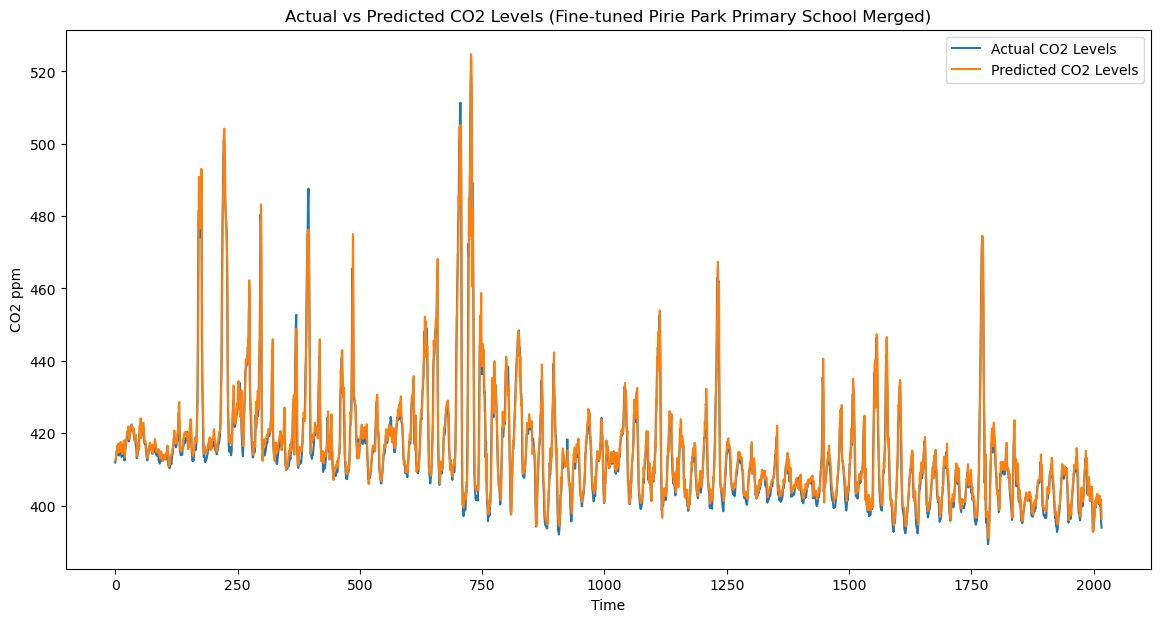

In [84]:
# Plotting predictions vs actual values for the best fine-tuned model
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual_best, label='Actual CO2 Levels')
plt.plot(predictions_best_inv, label='Predicted CO2 Levels')
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
plt.title('Actual vs Predicted CO2 Levels (Fine-tuned Pirie Park Primary School Merged)')
plt.legend()
plt.show()

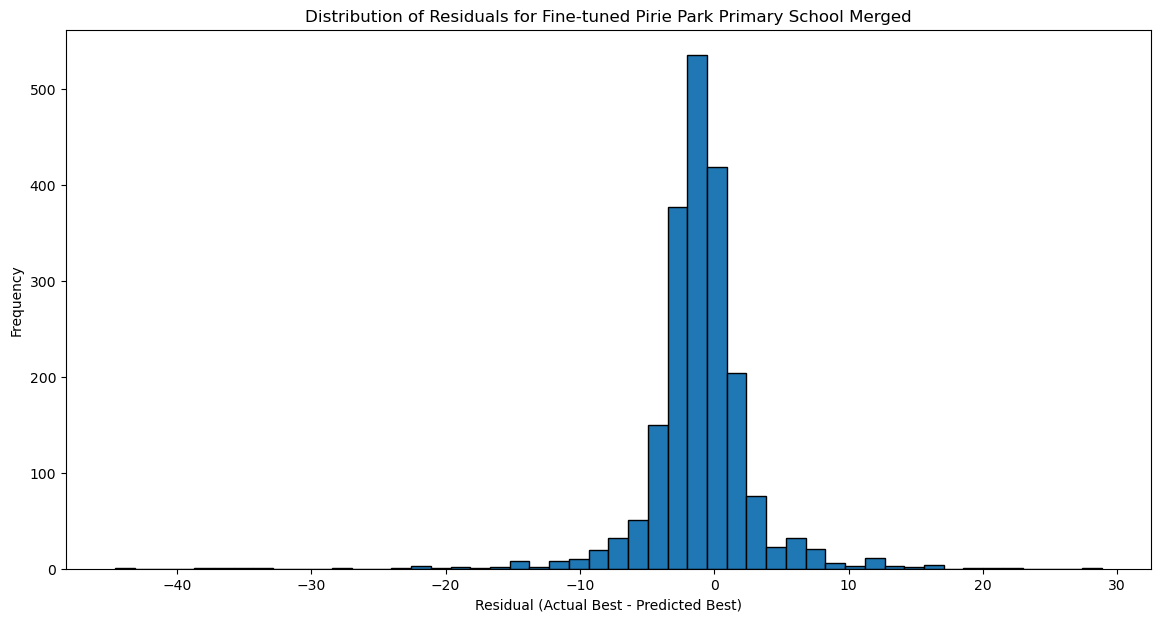

In [85]:
# Plotting residuals
residuals = y_test_actual_best - predictions_best_inv
plt.figure(figsize=(14, 7))
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residual (Actual Best - Predicted Best)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals for Fine-tuned Pirie Park Primary School Merged')
plt.show()

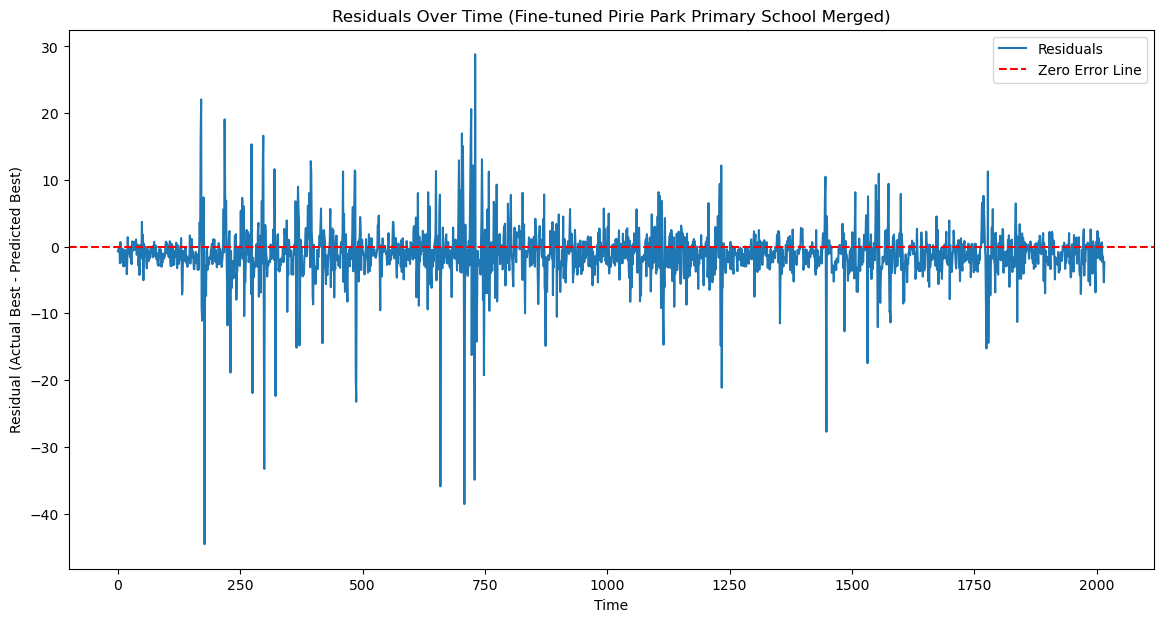

In [86]:
# Plotting residuals over time
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Time')
plt.ylabel('Residual (Actual Best - Predicted Best)')
plt.title('Residuals Over Time (Fine-tuned Pirie Park Primary School Merged)')
plt.legend()
plt.show()

### Best Model

In [83]:
# Source: https://keras.io/getting_started/faq/
# Saving the best model
model_save_path = "lstm_co2xweather_pp.keras"
best_lstm_co2xweather_model.save(model_save_path)

print(f"Best model saved as {model_save_path}")

Best model saved as lstm_co2xweather_pp.keras
